## Preparing data from Lisa dataset

This notebook generates xml files and a pickle data file for a single class from Lisa dataset.
File location should be:
```
lisa/
    img/
        imgpool/
                img1.jpg
                img2.jpg
                ...
        useimg/(blank file)
        
    xml/(blank file)
    
    annotations.csv
    
    lisadata_preparation.ipynb (this file)
```

Please have all image files in jpeg format, because that is the only tested file format.
execute:  
`cd img/ && mogrify -format jpg *.png && rm *.png && cd ..`

annotations.csv should have the following structure, derived from the original Lisa dataset CSV format:
```
Filename;Annotation tag;Upper left corner X;Upper left corner Y;Lower right corner X;Lower right corner Y;Occluded,On another road;Origin file;Origin frame number;Origin track;Origin track frame number
```

In [16]:
## Import necessary modules ##

import pickle
import os
import subprocess
import pandas as pd
import numpy as np
from PIL import Image
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

    
## set constants ##

jpegimagepath = 'img/imgpool/'
xmlfile_destination = 'xml/'
csv_name = 'annotations.csv'
annotation_name = 'merge' # name of the annotation you want to train on

In [17]:
## parse information from csv data ##

df1 = pd.read_csv(csv_name)
df1 = df1[df1['Annotation tag'] == annotation_name]

df1 = df1.drop(['Unnamed: 0',
              'Occluded,On another road',
              'Origin file',
              'Origin frame number',
              'Origin track frame number',
              'Origin track'],
             axis=1)

df1 = df1.rename(index=str,
               columns={'Filename': 'filename',
                        'Annotation tag': 'object',
                        'Upper left corner X': 'xmin',
                        'Upper left corner Y': 'ymin',
                        'Lower right corner X': 'xmax',
                        'Lower right corner Y': 'ymax'})

df1 = df1.replace({'png': 'jpg'}, regex=True)


## parse information from image data ##

# move df1 images to img/useimg/
subprocess.call(['rm img/useimg/*'], shell=True)
for i in range(len(df1)):
    f = df1['filename'][i]
    c = 'cp ' + jpegimagepath + f + ' img/useimg/'
    subprocess.call([c], shell=True)

# gather img information into df2
imgfile_names = os.listdir('img/useimg/')
annotation_list = []
imagesize_list = []

for name in imgfile_names:
    im = Image.open(jpegimagepath + name)
    t = list(im.size)
    t.insert(0,name)
    imagesize_list.append(t)
    
df2 = pd.DataFrame(imagesize_list).rename(index=str, columns={0: 'filename',
                                                              1: 'width',
                                                              2: 'height'})


## concatenate two dataframes together ##
df = pd.merge(df1, df2)
df['coord'] = df[['xmin','ymin','xmax','ymax']].values.tolist()
df = df.groupby(['filename','object','height','width'])['coord'].apply(list)
df = pd.DataFrame(df).reset_index()
df['d'] = df.apply(lambda row: {row['object']:row['coord']}, axis=1)
df = df.groupby(['filename','height','width'])['d'].apply(list)

df[:5]

filename                         height  width
merge_1323803242.avi_image0.jpg  480     704        [{'merge': [[167, 14, 231, 73]]}]
merge_1323803242.avi_image1.jpg  480     704        [{'merge': [[147, 10, 219, 71]]}]
merge_1323816805.avi_image4.jpg  480     704      [{'merge': [[146, 207, 222, 291]]}]
merge_1323816805.avi_image5.jpg  480     704       [{'merge': [[98, 195, 179, 289]]}]
merge_1323816805.avi_image6.jpg  480     704       [{'merge': [[40, 175, 127, 276]]}]
Name: d, dtype: object

In [18]:
## generate XML files ##
subprocess.call(['rm xml/*'], shell=True)
x = 0
for row in df:
    annotation = ET.Element('annotation')
    filename = ET.Element('filename')
    size = ET.Element('size')
    height = ET.SubElement(size, 'height')
    width = ET.SubElement(size, 'width')
    depth = ET.SubElement(size, 'depth')
    
    filename.text = df.index[x][0]
    height.text = str(df.index[x][1])
    width.text = str(df.index[x][2])
    annotation.extend((filename, size))
    
    for i in range(len(df[x][0][annotation_name])):
        obj = ET.SubElement(annotation, 'object')
        bndbox = ET.SubElement(obj, 'bndbox')
        name = ET.SubElement(obj, 'name')
        xmin = ET.SubElement(bndbox, 'xmin')
        ymin = ET.SubElement(bndbox, 'ymin')
        xmax = ET.SubElement(bndbox, 'xmax')
        ymax = ET.SubElement(bndbox, 'ymax')
        
        name.text = annotation_name
        xmin.text = str(df[x][0][name.text][i][0])
        ymin.text = str(df[x][0][name.text][i][1])
        xmax.text = str(df[x][0][name.text][i][2])
        ymax.text = str(df[x][0][name.text][i][3])
        
    tree = ET.ElementTree(annotation)
    ET.dump(tree)
    tree.write(xmlfile_destination + '.'.join(filename.text.split('.')[:-1]) + '.xml')
    x+=1

<annotation><filename>merge_1323803242.avi_image0.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>167</xmin><ymin>14</ymin><xmax>231</xmax><ymax>73</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1323803242.avi_image1.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>147</xmin><ymin>10</ymin><xmax>219</xmax><ymax>71</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1323816805.avi_image4.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>146</xmin><ymin>207</ymin><xmax>222</xmax><ymax>291</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1323816805.avi_image5.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>98</xmin><ymin>195</ymin><xmax>179</xmax><ymax>289</ymax></bndbox><name>merge</name></object></a

<annotation><filename>merge_1323821565.avi_image6.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>565</xmin><ymin>240</ymin><xmax>595</xmax><ymax>273</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1323821565.avi_image7.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>557</xmin><ymin>242</ymin><xmax>588</xmax><ymax>277</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1323821565.avi_image8.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>550</xmin><ymin>252</ymin><xmax>581</xmax><ymax>287</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1323821565.avi_image9.jpg</filename><size><height>480</height><width>704</width><depth /></size><object><bndbox><xmin>542</xmin><ymin>254</ymin><xmax>575</xmax><ymax>292</ymax></bndbox><name>merge</name></objec

<annotation><filename>merge_1331865721.avi_image9.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>730</xmin><ymin>81</ymin><xmax>814</xmax><ymax>165</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1331866392.avi_image0.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>577</xmin><ymin>187</ymin><xmax>606</xmax><ymax>215</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1331866392.avi_image1.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>581</xmin><ymin>189</ymin><xmax>610</xmax><ymax>217</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1331866392.avi_image10.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>617</xmin><ymin>170</ymin><xmax>658</xmax><ymax>211</ymax></bndbox><name>merge</name></o

<annotation><filename>merge_1333390034.avi_image5.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>792</xmin><ymin>129</ymin><xmax>867</xmax><ymax>203</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1333390034.avi_image6.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>860</xmin><ymin>102</ymin><xmax>952</xmax><ymax>195</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1333390051.avi_image0.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>606</xmin><ymin>185</ymin><xmax>637</xmax><ymax>216</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1333390051.avi_image1.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>617</xmin><ymin>179</ymin><xmax>650</xmax><ymax>213</ymax></bndbox><name>merge</name></o

<annotation><filename>merge_1333394402.avi_image17.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>58</xmin><ymin>100</ymin><xmax>135</xmax><ymax>192</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1333394402.avi_image2.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>462</xmin><ymin>195</ymin><xmax>488</xmax><ymax>221</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1333394402.avi_image3.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>456</xmin><ymin>194</ymin><xmax>482</xmax><ymax>220</ymax></bndbox><name>merge</name></object></annotation>
<annotation><filename>merge_1333394402.avi_image4.jpg</filename><size><height>522</height><width>1024</width><depth /></size><object><bndbox><xmin>447</xmin><ymin>188</ymin><xmax>473</xmax><ymax>214</ymax></bndbox><name>merge</name></o

In [19]:
## extract data from xml and create pickle data ##

class XML_preprocessor(object):

    def __init__(self, data_path):
        self.path_prefix = data_path
        self.num_classes = 1
        self.data = dict()
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ET.parse(self.path_prefix + filename)
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                for bounding_box in object_tree.iter('bndbox'):
                    xmin = float(bounding_box.find('xmin').text)/width
                    ymin = float(bounding_box.find('ymin').text)/height
                    xmax = float(bounding_box.find('xmax').text)/width
                    ymax = float(bounding_box.find('ymax').text)/height
                bounding_box = [xmin,ymin,xmax,ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find('name').text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            image_name = root.find('filename').text
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data
    
    def _to_one_hot(self,name):
        one_hot_vector = [0] * self.num_classes
        if name == annotation_name:
            one_hot_vector[0] = 1
            """
        elif name == 'bicycle':
            one_hot_vector[1] = 1
        elif name == 'bird':
            one_hot_vector[2] = 1
        elif name == 'boat':
            one_hot_vector[3] = 1
        elif name == 'bottle':
            one_hot_vector[4] = 1
        elif name == 'bus':
            one_hot_vector[5] = 1
        elif name == 'car':
            one_hot_vector[6] = 1
        elif name == 'cat':
            one_hot_vector[7] = 1
        elif name == 'chair':
            one_hot_vector[8] = 1
        elif name == 'cow':
            one_hot_vector[9] = 1
        elif name == 'diningtable':
            one_hot_vector[10] = 1
        elif name == 'dog':
            one_hot_vector[11] = 1
        elif name == 'horse':
            one_hot_vector[12] = 1
        elif name == 'motorbike':
            one_hot_vector[13] = 1
        elif name == 'person':
            one_hot_vector[14] = 1
        elif name == 'pottedplant':
            one_hot_vector[15] = 1
        elif name == 'sheep':
            one_hot_vector[16] = 1
        elif name == 'sofa':
            one_hot_vector[17] = 1
        elif name == 'train':
            one_hot_vector[18] = 1
        elif name == 'tvmonitor':
            one_hot_vector[19] = 1
            """
        else:
            print('unknown label: %s' %name)
        return one_hot_vector
    
data = XML_preprocessor(xmlfile_destination).data
pickle.dump(data,open('data.p','wb'))

## check if the image and the annotation is right
This step is optional. Everytime this step is executed, it automatically picks random picture and show it with an annotation bounding box.

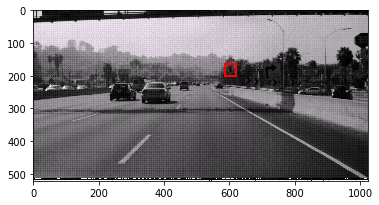

In [20]:
## import necessary modules ##
import cv2
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline


## pick random picture and show ##
rand = randint(0,len(df.index))
file = df[[rand]].index[0][0]
PATH = jpegimagepath + file
image = cv2.imread(PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image/255.)
currentAxis = plt.gca()


## add bounding box ##
# TODO: make multiple bounding boxes
xmin_p, ymin_p, xmax_p, ymax_p = df.loc[pd.IndexSlice[file]][0][0][annotation_name][0]

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
color = colors[0]
coords = (xmin_p, ymin_p), xmax_p-xmin_p+1, ymax_p-ymin_p+1

currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))

plt.show()